<a href="https://colab.research.google.com/github/n-vit/YaP_Projects/blob/main/prediction_of_outflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Техническое задание

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# План работы:

1) Обзор, исследовательский анализ и первичная предобработка исходных данных
- посмотрим на фреймы, соберем в один общий,
- проверим пропуски, дубликаты, форматы значений
- проанализируем признаки, оценим объем выборки, взаимозависимости, выбросы, определим целевой признак и признаки, которые не будем использовать в модели

2) Изучение подходов по прогнозированию оттока клиентов. Выбор методологии. 
- уточним задачу, что именно мы будем считать оттоком, проанализируем подходы к прогнозам оттока, которые уже используются на рынке
- поскольку нам нужно будет решить задачи классификации, выберем наиболее перспективные модели, которые будем использовать в проекте и оценивать

3) Подготовка данных для моделирования и обучение модели 
- отбор значимых признаков
- выделение тестовой выборки (0.25)
- категоризация признаков и сокращение разрядности
- обучение моделей, подбор гиперпараметров, оценка результатов полученных на кросс-валидации
- выбор решения для теста

4) Тест модели, оценка эффективности, доработки

5) Отчет о выполнении проекта

6) Итоговый вывод и рекомендации заказчику. 


## Вопросы куратору:
- Правильно ли я понимаю задачу - среди клиентов, чей контракт не закончен нужно будет найти похожих на тех, которые закончили сотрудничество - это и будет предсказанный отток? ошибками считаются как не предсказанный отток, так и ложноположительное предсказание. Классифицируются два признака - отток и нет. 
- Увидел интересное решение https://habr.com/ru/company/rostelecom/blog/444694/ стоит ли попробовать пойти по этому пути, или для учебного проекта это неподъемно? можно ли будет использовать GPU Яндекса?
- Аномально много контрактов заключено в 2014, и аномально мало до этого. Что это - промо, ошибки, старт услуги?
- Почему с 2013 до 2019 г. вообще не было расторгнуто ни одного контракта, и вообще за 8 лет расторжение контрактов было только в четырех месяцах. В жизни так не бывает. Возможно не хватает данных, или это обучение и "и так сойдет"?

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> По твоим вопросам:
    
1. По сути все верно, модель находит похожие данные и относит их к оттоку, либо наоборот, к лояльному классу. Ошибки бывают первого и второго рода, как ты и написал. У нас простая классификация, класс 0 и 1. Целевая метрика - ROC-AUC.
    
2. Интересная статья, но боюсь она не впишется в двухнедельный финальный спринт. Мы решаем задачу таким образом: допустим, наш Заказчик ежемесячно планирует оценивать, какие клиенты могут попасть в отток, а какие нет. Посчитав результаты по модели, мы поймем, какие клиенты потенциально отточные, и им можем предложить бонусы и различные промокоды, чтобы повысить лояльность.
    
В статье есть некоторая аналогия с временным рядом, но здесь мы не рассматриваем такую задачу. Что касается GPU, можно использовать Облако Яндекса или Google Colab. Пока что многие больше работают на Colab.
  
3. 2014 год — это начало активной фазы работы Телеком компании. Скорее всего в 2013 была небольшая группа клиентов, отлаживали оборудование. 
    
4. Дело в том, что мы работаем с историческими данными, поэтому такая ситуация. Скорее всего Заказчик ранее не обращал на отток клиентов и не заносил данные в базу. Но когда отток стал значительным, данные попали в базу, и записали их все в одну дату. Затем отток стали фиксировать ежемесячно. Это одна из проблем исторических данных, но часть встречается в реальной практике.
    
</div>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from numpy import argmax 

from sklearn.preprocessing import OneHotEncoder 


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, plot_confusion_matrix


import lightgbm as lgb

 
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# Исходные данные


## Описание услуг
Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных.

Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

**Описание полей данных:**

- BeginDate – дата начала пользования услугами.
- EndDate – дата окончания пользования услугами.
- Type – тип оплаты: ежемесячный, годовой и тд.
- PaperlessBilling – безналичный расчет.
- PaymentMethod – способ оплаты.
- MonthlyCharges – ежемесячные траты на услуги.
- TotalCharges – всего потрачено денег на услуги.
- Dependents – наличие иждивенцев.
- Senior Citizen – наличие пенсионного статуса по возрасту.
- Partner – наличие супруга(и).
- MultipleLines – наличие возможности ведения параллельных линий во время звонка.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

<div class="alert alert-success">
<b>✔️ Комментарий тимлида:</b> Здорово, что добавил описание проекта и обозначения признаков — так постороннему человеку будет проще ознакомиться с работой.
    
Как рекомендация, можно написать основную цель проекта.
    
</div>

# Исследовательский анализ

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  contract = pd.read_csv('/content/drive/MyDrive/final_provider/contract.csv', parse_dates=['BeginDate', 'EndDate'])
  personal = pd.read_csv('/content/drive/MyDrive/final_provider/personal.csv')
  internet = pd.read_csv('/content/drive/MyDrive/final_provider/internet.csv')
  phone = pd.read_csv('/content/drive/MyDrive/final_provider/phone.csv')
except:
  contract = pd.read_csv('/datasets/final_provider//contract.csv', parse_dates=['BeginDate', 'EndDate'])
  personal = pd.read_csv('/datasets/final_provider/personal.csv')
  internet = pd.read_csv('/datasets/final_provider/internet.csv')
  phone = pd.read_csv('/datasets/final_provider/phone.csv')


In [ ]:
contract.head(3)

In [ ]:
df = ((contract.set_index('customerID').join(phone.set_index('customerID')))\
      .join(personal.set_index('customerID')))\
      .join(internet.set_index('customerID'))
df.head(3)

In [ ]:
df.info()

In [ ]:
df.query('EndDate == "No"')['EndDate'].count()

Из 7043 клиентов действующие контракты у 5174, остальные в оттоке. 

In [ ]:
df['EndDate'].unique()

In [ ]:
display(df.query('EndDate != "No"').describe(include='all'))

- пропуски в данных об интернет-услугах у пользователей присоединенных из фрейма phone
- бинарные признаки дополнительных услуг и электронного счета
- странная история с общей суммой пополнений. значений меньше чем строк, и формат object
- 

https://habr.com/ru/company/rostelecom/blog/444694/


Добавим бинарный признак ушедшего клиента

In [ ]:
df['Gone'] = 1
df.loc[df['EndDate'] == 'No', 'Gone'] = 0

In [ ]:
display(pd.merge(df.query('Gone == 1')['MonthlyCharges'].describe(), 
                 df['MonthlyCharges'].describe(), 
                 left_index=True, 
                 right_index=True, 
                 suffixes=(' Gone', ' All')))

Да... нас покидают лучшие. Ежемесячные пополнения счета у ушедших клиентов больше среднего.

Ядро ушедших клиентов (квартили 25-75) тратят на связь заметно больше. 


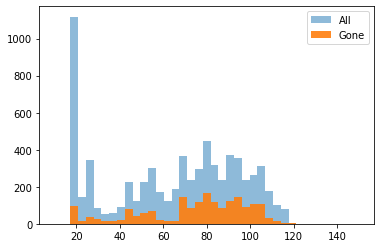

In [ ]:
bins = np.linspace(10, 150, 40)
plt.hist(df['MonthlyCharges'], bins, alpha=0.5, label='All')
plt.hist(df.query('Gone == 1')['MonthlyCharges'], bins, alpha=0.9, label='Gone')
plt.legend(loc='upper right')

plt.show()

Те кто пополняет баланс минимальной суммой каждый месяц - уходят гораздо реже. Что касается остальных сегментов чека - распределение ушедших идентичное общему. 

посмотрим на отток с точки зрения базовых услуг: добавим признак основной услуги: телефон, интернет, или все сразу

In [ ]:
df['InternetService'].fillna('No',inplace = True) 
df['Services'] = 'All services' 
df.loc[(df['InternetService'] != 'No') & (~df.index.isin(phone['customerID'])),
            'Services'] = 'Net only' 
df.loc[(df['InternetService'] == 'No') & (df.index.isin(phone['customerID'])),
            'Services'] = 'Phone only' 

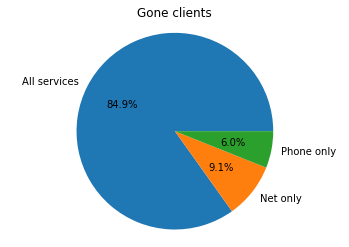

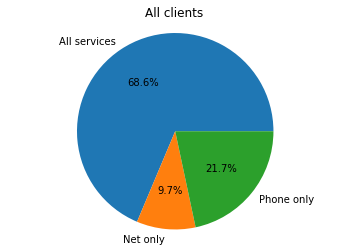

In [ ]:
labels = 'All services', 'Net only', 'Phone only'

fig1, ax1 = plt.subplots()
ax1.pie(pd.merge(df.query('Gone == 1')['Services'].value_counts(), 
                 df['Services'].value_counts(),
                 how='outer', 
                 left_index=True, 
                 right_index=True, 
                 suffixes=(' Gone', ' All'))['Services Gone'], labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Gone clients")

fig2, ax2 = plt.subplots()
ax2.pie(pd.merge(df.query('Gone == 1')['Services'].value_counts(), 
                 df['Services'].value_counts(),
                 how='outer', 
                 left_index=True, 
                 right_index=True, 
                 suffixes=(' Gone', ' All'))['Services All'], labels=labels, autopct='%1.1f%%')
ax2.axis('equal') 
plt.title("All clients")
plt.show()

Никаких открытий. Консервативные пользователи телефонной линии и провайдера тоже менять не любят, а вот потребители комплексных услуг куда-то утекают. Те кто пользуются только интернетом - стабильны. Их доля в оттоке такая же, как в общей выборке.  


Посмотрим на LTV, только сначала разберемся, почему TotalCharges это object

In [ ]:
df['TotalCharges'].sort_values().unique()

Есть клиенты, у которых пробел в платежах. Клиент есть, а денег нет. 

In [ ]:
df.query('TotalCharges == " "')['BeginDate'].sort_values().unique()

Только один месяц регистрации, и он последний во фрейме. Значит просто не успели оплатить. Попадут ли они в отток - вообще непонятно, если их немного - лучше удалить

In [ ]:
df.query('TotalCharges == " "')['BeginDate'].count()

In [ ]:
df = df.query('TotalCharges != " "')
df['TotalCharges'] = df['TotalCharges'].astype(np.float64)
df.shape

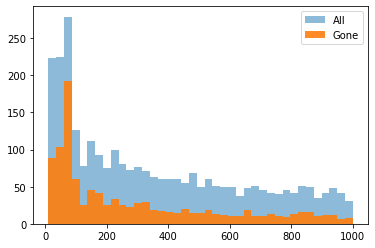

In [ ]:
bins = np.linspace(10, 1000, 40)
plt.hist(df['TotalCharges'], bins, alpha=0.5, label='All')
plt.hist(df.query('Gone == 1')['TotalCharges'], bins, alpha=0.9, label='Gone')
plt.legend(loc='upper right')

plt.show()

А вот c LTV все ровно. Рельеф гистограммы ушедших клиентов повторяет общий, это значит, что в отток попадают все клиенты, независимо от их времени сотрудничества. А еще - аномалия в самом дешевом сегменте при увеличении масштаба пропадает. Это значит что клиентов, которые пополняют минималку каждый месяц, тоже нужно беречь. С точки зрения ценности за все время сотрудничества - они важны не менее остальных. 

Посмотрим на время сотрудничества:


In [ ]:
df.query('EndDate != "No"')['EndDate'].sort_values().unique()

In [ ]:
df['duration'] = pd.to_datetime('2020-02-01', format='%Y-%m-%d') - df['BeginDate']
df.loc[df['EndDate'] != 'No','EndDate']['duration'] = pd.to_datetime(df.loc[df['EndDate'] != 'No','EndDate'])- df['BeginDate']
df['duration'] = pd.to_numeric(df['duration'].dt.days, downcast='integer')

In [ ]:
df.describe()

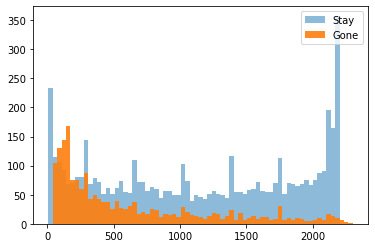

In [ ]:
bins = np.linspace(10, 2300, 70)
plt.hist(df.query('Gone == 0')['duration'], bins, alpha=0.5, label='Stay')
plt.hist(df.query('Gone == 1')['duration'], bins, alpha=0.9, label='Gone')
plt.legend(loc='upper right')

plt.show()

Вот такая история - самый высокий риск оттока в первые полгода сотрудничества. Зато если удалось удержат - то потом клиенты остаются надолго. (хорошо бы если так, но мы помним что мы отток начали недавно считать...)

Разберемся с услугами, только сначала заполним пропуски, которые появились из-за "телефонщиков"

In [ ]:
df[['MultipleLines',
   'InternetService',
   'OnlineSecurity',
   'OnlineBackup',
   'DeviceProtection',
   'TechSupport',
   'StreamingTV',
   'StreamingMovies']].fillna('No',inplace = True)

In [ ]:
display(df.query('Gone == 0')[['MultipleLines',
   'InternetService',
   'OnlineSecurity',
   'OnlineBackup',
   'DeviceProtection',
   'TechSupport',
   'StreamingTV',
   'StreamingMovies']].describe())

In [ ]:
display(df.query('Gone == 1')[['MultipleLines',
   'InternetService',
   'OnlineSecurity',
   'OnlineBackup',
   'DeviceProtection',
   'TechSupport',
   'StreamingTV',
   'StreamingMovies']].describe())

Разница есть:
-  Ушедшие клиенты предпочитали оптику, а оставшиеся сидят на DSL, 
- Ушедшим гораздо реже требуется онлайн-бэкап

Доли остальных услуг вполне сопоставимы. 

## Выводы исследовательского анализа:

1. Отток стали замерять только последние 4 месяца, при этом в первый месяц замера внесли все данные за предыдущие периоды. 

2. Ушедшие клиенты в среднем тратили больше денег на связь ежемесячно, но LTV их ниже, за счет более короткого времени сотрудничества

3. Критическое время сотрудничества - первые полгода. Как правило, клиенты преодолевающие этот барьер остаются надолго

4. Уходящие клиенты в целом более разборчивы. Предпочитают быстрый интернет и гораздо реже пользуются только телефоном. Реже используют онлайн-бэкап. 

Стоит провести конкурентный анализ по сегментам оптоволоконного интернета и комплексным услугам связи, возможно мы не в рынке, и удерживаем только консервативных клиентов, не рассматривающих другие предложения. Высокий отток в первые полгода может свидетельствовать о проблемах с качеством услуг, относительно предыдущего провайдера. 


Фрейм содержит качественную информацию, признаков достаточно, чтобы обучить модели классификации и попробовать решить задачу предсказания оттока по информации о поведении и предпочтениях клиента.  

## Подготовка и обучение модели

Разберемся с признакамии, и определим, какие из них нужно оставить:

- Вместо даты начала и окончания сотрудничества оставим столбец с данными о его продолжительности.
- Удалим столбец с сервисами - он помог в аналитике, но дублирует данные других признаков
- Целевым признаком будет столбец Gone

In [ ]:
df.drop(['BeginDate', 'EndDate', 'Services'], axis = 1, inplace = True)

Выделим тестовую выборку:

In [ ]:
train, test = train_test_split(df, test_size = 0.25, random_state = 120922)

Закодируем категориальные переменные

In [ ]:
train = pd.get_dummies(train, drop_first = True)

и сократим разрядность, там где это возможно

In [ ]:
df_float = train.select_dtypes(include=['float']) 
df_float = df_float.apply(pd.to_numeric,downcast='float')
train[df_float.columns] = df_float

df_int = train.select_dtypes(include=['int']) 
df_int = df_int.apply(pd.to_numeric,downcast='unsigned') 
train[df_int.columns] = df_int

In [ ]:
train.info()

Выглядит неплохо, сделаем то же с тестовой выборкой

In [ ]:
test = pd.get_dummies(test, drop_first = True)
df_float = test.select_dtypes(include=['float']) 
df_float = df_float.apply(pd.to_numeric,downcast='float')
test[df_float.columns] = df_float

df_int = test.select_dtypes(include=['int']) 
df_int = df_int.apply(pd.to_numeric,downcast='unsigned') 
test[df_int.columns] = df_int
test.info()

Количество признаков и их порядок во фрейме сохранился, Осталось отделить таргет и фичи, и можно приступать к работе с моделями

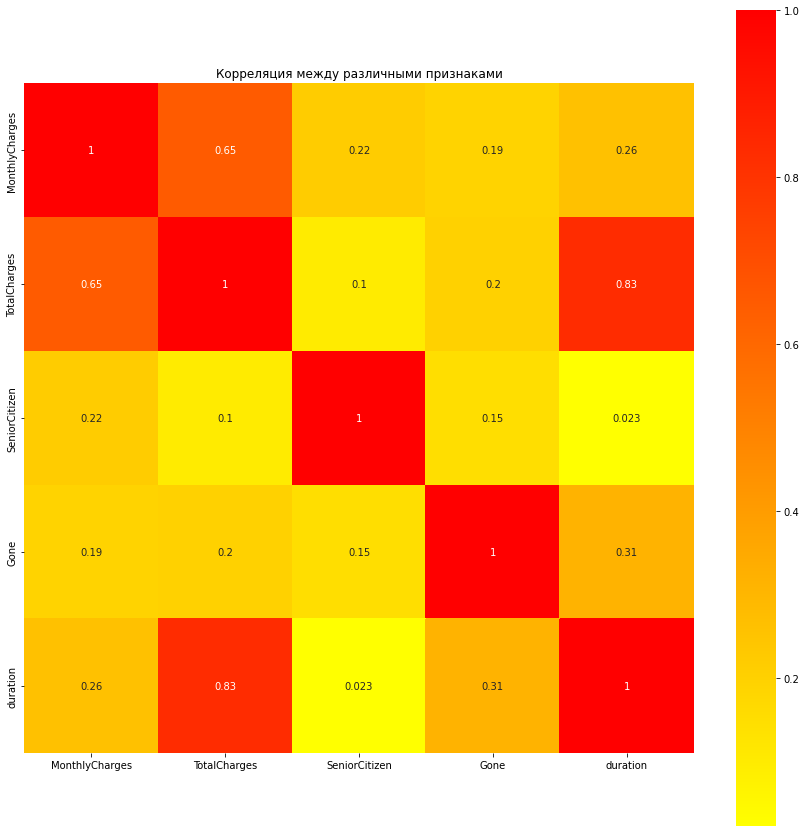

In [ ]:
pearson = abs(df.corr())
plt.figure(figsize=(15,15))
sns.heatmap(pearson, vmax=1, square=True,annot=True,cmap='autumn_r')

plt.title('Корреляция между различными признаками')
plt.show()

In [ ]:
df.drop(['TotalCharges'], axis = 1, inplace = True)

In [ ]:
features_train = train.drop('Gone', axis = 1)
target_train = train['Gone']

features_test = test.drop('Gone', axis = 1)
target_test = test['Gone']

print('Обучающая выборка:', features_train.shape)
print('Тестовая выборка', features_test.shape)


<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> 

Добавил палитру с корреляцией на категоризированном фрейме (train). На мой взгляд ничего критичного:

- Общая выручка от клиента логично в высокой зависимости от продолжительности сотрудничества (0,89). **Нужно ли удалять один из этих признаков, и если да - как определить какой из них оставить?**

- Ежемесячные платежи в высокоц корреляции того, подключен ли быстрый интернет по оптике, и вообще подключен ли интернет
- Есть зависимость между продолжительностью сотрудничества и типом оплаты

Для целевого признака можно выделить признаки с заметной корреляцией:
- наличие быстрого интернета
- тип оплаты
- метод доставки чека

При этом максимальный коэффициент корреляции не превышает 0,31, а это нижняя граница между слабой и заметной зоной корреляции. 

**Ниже добавил масштабирование признаков**
 </div>

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

## Логистическая регрессия

In [ ]:
parameters = {
             'penalty' : ['l1','l2'], 
             'C'       : np.logspace(-3,3,7),
             'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],}
lr_model = LogisticRegression()
lr_model = GridSearchCV(lr_model,                    
                     param_grid = parameters,   
                     scoring='roc_auc',      
                     cv=5)        

In [ ]:
'''
%%time
lr_model.fit(features_train,target_train)
'''

Вывод результата:

```
CPU times: user 11.9 s, sys: 9.02 s, total: 20.9 s
Wall time: 10.9 s
GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')
```



In [ ]:
lr_prediction_proba = lr_model.predict_proba(features_train)[:,1]
lr_prediction = lr_model.predict(features_train)
lr_auc_roc = cross_val_score(lr_model, 
                             features_train, 
                             target_train, cv=5, 
                             scoring = 'roc_auc').mean()
lr_acc = cross_val_score(lr_model, 
                         features_train, 
                         target_train, cv=5, 
                         scoring = 'accuracy').mean()

best_params_lr = lr_model.best_params_

print('Лучшие параметры для логистической регрессии на кросс-валидации =', best_params_lr)
print()
print('Логистическая регрессия, auc_roc:',lr_auc_roc )
print('Логистическая регрессия, accuracy:',lr_acc )

Вывод результатов:

```
Лучшие параметры для логистической регрессии на кросс-валидации = {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}

Логистическая регрессия, auc_roc: 0.8371770849507836
Логистическая регрессия, accuracy: 0.800152342239449
```



Результат на кросс-валидации на "четверку" - уже неплохо

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Неплохой результат для логистической регрессии!
      
</div>

<div class="alert alert-danger">
<b>🚫 Комментарий ревьювера:</b> Нужно поправить расчет метрик на выборке train — для этого нужно применять кросс-валидацию. Поскольку ты используешь GridSearchCV, для метрики roc-auc можно посмотреть так:
    
    roc_auc_lr = lr_model.best_score_
    
Либо можно посчитать на кросс-валидации с помощью функции cross_val_score:
    
    roc_auc_lr = cross_val_score(model_lr, features_train, target_train, cv=5, scoring = 'roc_auc').mean()
    
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
    
Для accuracy также нужно посчитать через функцию cross_val_score.
    
Все дело в том, что модель уже «видела» выборку train, поэтому качество предсказания выше. В случае линейных моделей это не сильно сказывается, но решающие деревья и бустинги показывают слишком оптимистичные результаты.
</div>

<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> 
Исправил, спасибо
 </div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Да, отлично!
    
</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера v2:</b> Далее проверял работу локально.
    
</div>

### Случайный лес

In [ ]:
rfc_model = GridSearchCV(RandomForestClassifier(criterion = 'entropy', 
                                                class_weight='balanced'),{
                            'max_depth': range(3,15,3),
                            'n_estimators': range(10,100, 10),
                            'min_samples_split' : range(4,28,4),
                            'min_samples_leaf' : range(3,13,2)},
                             cv = 5,
                             scoring = 'roc_auc',
                              n_jobs=-1)

In [ ]:
%%time
rfc_model.fit(features_train,target_train)


Вывод результата:

```
CPU times: user 51 s, sys: 2.88 s, total: 53.9 s
Wall time: 16min 44s
GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy'),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 15, 3),
                         'min_samples_leaf': range(3, 13, 2),
                         'min_samples_split': range(4, 28, 4),
                         'n_estimators': range(10, 100, 10)},
             scoring='roc_auc')
```



In [ ]:
best_params_rfc= rfc_model.best_params_

In [ ]:
%%time
rfc_model = RandomForestClassifier(**best_params_rfc, 
                                   random_state=120922)

rfc_model.fit(features_train, target_train)

rfc_prediction_proba = rfc_model.predict_proba(features_train)[:,1]
rfc_predictions = rfc_model.predict(features_train)


rfc_roc = cross_val_score(rfc_model, features_train, target_train, cv=5, scoring = 'roc_auc').mean()
rfc_acc = cross_val_score(rfc_model, features_train, target_train, cv=5, scoring = 'accuracy').mean()

print('Лучшие параметры для случайного леса на кросс-валидации =', best_params_rfc)
print()
print('Случайный лес, auc_roc:',rfc_roc )
print('Случайный лес, accuracy:',rfc_acc)

Вывод результата

```
Лучшие параметры для случайного леса на кросс-валидации = {'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 16, 'n_estimators': 60}

Случайный лес, auc_roc: 0.8738316833105919
Случайный лес, accuracy: 0.8357977283559809
CPU times: user 2.93 s, sys: 5.56 ms, total: 2.94 s
Wall time: 2.94 s
```



~Случайный лес долго учился, но зато результат превзошел все ожидания 0,95 AUC-ROC~

Стало правдоподобнее. 0,87 - вполне вписывается в условия задачи



### Градиентный бустинг

In [ ]:
estimator = lgb.LGBMClassifier(class_weight='balanced', 
                               boosting_type = 'gbdt', 
                               objective='binary',
                               random_state=120922, 
                               reg_alpha = 0, 
                               metric = 'auc', 
                               max_depth = 1, silent=True)
param_grid = { 'learning_rate': [0.01, 0.1 ,0.5], 'n_estimators': [2,10,60], 'min_child_samples' : [10,50,100]}
lgbm_model = GridSearchCV(estimator, param_grid, cv=5, scoring='roc_auc')

lgbm_model.fit(features_train, target_train) 

Вывод результата

```
GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', max_depth=1,
                                      metric='auc', objective='binary',
                                      random_state=120922, reg_alpha=0),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'min_child_samples': [10, 50, 100],
                         'n_estimators': [2, 10, 60]},
             scoring='roc_auc')
```



In [ ]:
%%time
lgbm_prediction_proba = lgbm_model.predict_proba(features_train)[:,1]
lgbm_prediction = lgbm_model.predict(features_train)
lgbm_roc = lgbm_model.best_score_
lgbm_acc = cross_val_score(lgbm_model, features_train, target_train, cv=5, scoring = 'accuracy').mean()

best_params_lgbm = lgbm_model.best_params_
print('Лучшие параметры для градиентного бустинга на кросс-валидации =', best_params_lgbm)
print()
print('Градиентный бустинг auc_roc:',lgbm_roc )
print('Градиентный бустинг accuracy:',lgbm_acc )

Вывод результата

```
Лучшие параметры для градиентного бустинга на кросс-валидации = {'learning_rate': 0.5, 'min_child_samples': 100, 'n_estimators': 60}

Градиентный бустинг auc_roc: 0.8852513882474178
Градиентный бустинг accuracy: 0.7806242974180957
CPU times: user 24.7 s, sys: 147 ms, total: 24.8 s
Wall time: 12.8 s
```



~Бустинг показал результат ниже, чем случайный лес.~

А вот и нет. Бустинг закономерно победил

**По результатам исследования трех моделей на кросс-валидации лучшие результаты показал градиентный бустинг LightGBM. Его и оставим для дальнейшего тестирования**

## Проверяем качество лучшей модели на тестовой выборке

In [ ]:
 %%time
test_prediction_proba = lgbm_model.predict_proba(features_test)[:,1]
test_prediction = lgbm_model.predict(features_test)

test_roc = roc_auc_score(target_test, test_prediction_proba)
test_acc = accuracy_score(target_test, test_prediction)

print('Градиентный бустинг на тестовой выборке auc_roc:',test_roc )
print('Градиентный бустинг на тестовой выборке accuracy:',test_acc )

Вывод результата

```
Градиентный бустинг на тестовой выборке auc_roc: 0.8858767309348705
Градиентный бустинг на тестовой выборке accuracy: 0.7895335608646189
CPU times: user 24.5 ms, sys: 1.64 ms, total: 26.1 ms
Wall time: 16.9 ms
```



На тестовой выборке бустинг показал 0,89 auc_roc, что соответвует высшей оценке 6sp в системе оценки заказчика, при минимальном пороге 4 sp. 

Модель справилась и выдала ожидаемый результат. 

# Отчет о выполнении проекта:


<div class="alert alert-info"> <b>ℹ️ Комментарий студента v2: </b> 

**Все пункты намеченного плана были выполнены**
    
Трудностей при выполнении проекта не возникло, т.к. данные хорошо структурированы и логичны. Аномалий, ошибок или значительных пропусков в данных не оказалось, поэтому проект был выполнен последовательно. 
    
К ключевым шагам проекта, которые позволили успешно решить задачу стоит отнести:
- выделение целевого признака, 
- выбор признаков для обучения модели, с учетом корреляции и структуры данных (отказ от использования временных рядов и данных об общей выручке по клиенту, в пользу продолжительности сотрудничества)
- выбор моделей классификаторов их обучение и анализ результатов. 


 </div>


Исследовательский анализ показал что данные об оттоке не собирались в течение всего временного ряда фрейма. 

Это нужно иметь ввиду оценивая результаты модели в следующие периоды. Время сотрудничества - важный признак, но для ушедших клиентов мы не знаем рельного времени сотрудничества, т.к. все прекращенные контракты до 2019 года были внесены в один месяц. Системное пополнение данных об оттоке в дальнейшем повысит надежность модели. 

**Предсказание оттока клиентов безусловно важная бизнес-задача для заказчика:** мы убедились что в отток попадают клиенты, приносящие выручку больше средней. Они избирательны и предпочитают современные технологии. 
В то же время реже других попадают в отток клиенты вносящие минимальную ежемесячную оплату и использующие только телефон.

Это **серьезные основания чтобы порекомендовать маркетингу провести полноценный конкурентный анализ**. 

В процессе предобработки:

- сформировали из четырех фреймов единую таблицу с данными по каждому клиенту
- заполнили пропуски на основании имеющихся данных по исходным таблицам
- удалили пропуски без очевидного источника для заполнения (11 строк с пропусками в общей выручке)
- привели данные к корректным форматам (числа и даты)
- добавили бинарный целевой признак - ушел клиент, или нет. 
- провели анализ корреляции числовых параметров, порезультатам которого исключили из фрейма информацию об общей выручке
- исключили из числа признаков числовые ряды (даты начала и окончания сотрудничества), заменив их на продолжительность сотрудничества в днях
- провели числовое кодирование признаков (OHE с удалением исходного столбца и визуальным сравнением признаков в учебной и тестовой выборке)
- провели масштабирование признаков (MinMaxScaler)

<div class="alert alert-info"> <b>ℹ️ Комментарий студента v2: </b> 

**Итоговый список признаков для обучения**: 
 
- MonthlyCharges 
- TotalCharges  
- SeniorCitizen
- duration             
- Type_One year       
- Type_Two year      
- PaperlessBilling_Yes   
- PaymentMethod_Credit card (automatic)  
- PaymentMethod_Electronic check   
- PaymentMethod_Mailed check 
- MultipleLines_Yes   
- gender_Male      
- Partner_Yes     
- Dependents_Yes   
- InternetService_Fiber optic     
- InternetService_No   
-  OnlineSecurity_Yes  
- OnlineBackup_Yes    
- DeviceProtection_Yes
- TechSupport_Yes     
- StreamingTV_Yes         
- StreamingMovies_Yes
 </div>

Выделили тестовую выборку 0,25% фрейма

Для проекта были обучены три модели с подбором гиперпараметров в коридорах значений:

- логистическая регрессия {'penalty' : ['l1','l2'], 'C': np.logspace(-3,3,7),'solver': ['newton-cg', 'lbfgs', 'liblinear'],}

- случайный лес {'max_depth': range(3, 15, 3),
                         'min_samples_leaf': range(3, 13, 2),
                         'min_samples_split': range(4, 28, 4),
                         'n_estimators': range(10, 100, 10)}
                         
- градиентный бустинг (LGBM) {'learning_rate': [0.01, 0.1, 0.5],
                         'min_child_samples': [10, 50, 100],
                         'n_estimators': [2, 10, 60]}

На всех моделях random_state=120922

модели были обучены на тренировочной выборке с подбором наилучших гиперпараметров кросс-валидацией (GridSearchCV). 
Для сравнения моделей использовались метрики auc-roc и accuracy

Итоговая модель - градиентный бустинг LGBM, показала лучшие результаты и на тестовой выборке обеспечила выполнение заданного стандарта auc-roc на гиперпараметрах:

- 'learning_rate': 0.5, 
- 'min_child_samples': 100, 
- 'n_estimators': 60

Градиентный бустинг на тестовой выборке auc_roc: 0.8858767309348705

Градиентный бустинг на тестовой выборке accuracy: 0.7895335608646189

CPU times: user 24.5 ms, sys: 1.64 ms, total: 26.1 ms
Wall time: 16.9 ms